# Simulating data with ironman

In this tutorial, we will see how to simulate RM data with the objective of include it in our proposals. First thing we need is to import ironman

In [1]:
import ironman
import numpy as np
import matplotlib.pyplot as plt

Then, we need to create a dictionary with the properties of the system we want to to observe. Lets take the case of TOI-3362b. Assuming a well-aligned orbit we have:

In [2]:
dct_system = {"per_p1":18.09537, # orbital period
       "aRs_p1":19.01,           # scaled semimajor axis
       "inc_p1":84.25,           # orbital inclination
       "vsini_star":20.2,        # stellar projected rotational velocity
       "p_p1":0.069,             # Rp/Rs
       "rv_prec":10.,            # RV error bar (m/s)
       "exp_time":300,           # Exposure time (sec)
       "e_p1":0.72,              # orbital eccentricity
       "omega_p1":60.5,          # argument of periastron 
       "teff_star":6800.,             # stellar Teff
       "R_spec":140000.,              # resolution of the spectrograph
       "lam_p1":1.2,             # sky-projected obliquity
       "t0_p1":2458529.32785,    # time of mid-transit
       "u":[0.32694400,0.33127792]} #quadratic limb darkening coefficients

Where we also assumed an exposure time of 300s and an RV presicion of 10 m/s for the ESPRESSO (R~140000) spectrograph.

Once the properties of the system are defined, we have to find the transit windows. In our case we know a window transit for the planet
on Dec 27, 2022. Converting that to BJD:

In [3]:
from astropy.time import Time

tr_window = ['2022-12-27T03:00:00', '2022-12-27T09:00:00']
tr_window = Time(tr_window, format='isot', scale='utc')
tr_window = tr_window.jd
print(tr_window)

[2459940.625 2459940.875]


So observations must be performed between those times. Now lets create our observation times assuming 300s exposure time.

In [4]:
bjd = np.arange(tr_window[0],tr_window[1],300.0/60.0/60.0/24.0)

And finally, lets simulate the data and plot it!

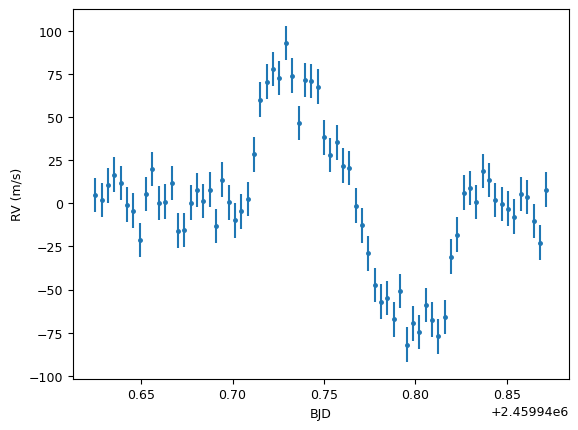

In [6]:
sim_data, error = ironman.create_RM_data(bjd,dct_system)

plt.errorbar(bjd,sim_data,error,fmt=".")
plt.xlabel("BJD")
plt.ylabel("RV (m/s)")
plt.show()

To see how well we can constrain the sky-projected obliquity using the simulated data we only have to input it into the ironman DataOrganizer and follow the same steps than for the real data.

In [7]:
times_lc, fluxes, fluxes_error = {}, {}, {}
times_rvs, rvs, rvs_err =  {}, {}, {}
times_RM, RM, RM_err =  {}, {}, {}

times_RM["ESPRESSO"], RM["ESPRESSO"], RM_err["ESPRESSO"] = bjd, sim_data, error

exp_times = {"ESPRESSO": 300.0/60.0/60.0/24.0}

In [8]:
data = ironman.DataOrganizer(output="Example 2 - Results",lc_time=times_lc,lc_data=fluxes,lc_err=fluxes_error,rv_time=times_rvs,rv_data=rvs,rv_err=rvs_err,rm_time=times_RM,rm_data=RM,rm_err=RM_err,verbose = True,exp_times=exp_times)

Reading data...
Data Ready!
Data saved ...
exp_times saved ...


In [9]:
priors = ironman.Priors("priors/Example2_priors.dat",data)

Priors dictionary ready...
Detecting fixed parameters...
Fixed K_p1 detected!
Fixed sigma_ESPRESSO detected!
Fixed gammadot detected!
Fixed gammadotdot detected!
Priors saved ...


In [10]:
fit = ironman.Fit(data=data,priors=priors,ta=0.)

Fit class initialized.


Here the ta parameter refers to an arbitrary time to calculate the RV slopes. By default ironman assumes it to be the time of the first RV measurements. Since we are only fitting "RM data", it will find an error. To solve, for now, we only have to set it manually to 0 (even if we are not fitting an RV slope like in this case)

In [11]:
postsamples = fit.run(n_live=500, nthreads = 24)

Running dynesty with 500 nlive and 24 threads


17645it [01:42, 171.76it/s, batch: 5 | bound: 26 | nc: 1 | ncall: 519691 | eff(%):  3.294 | loglstar: -207.170 < -200.391 < -201.810 | logz: -213.984 +/-  0.104 | stop:  0.840]      


Saved posteriors to Example 2 - Results/posteriors.txt


In [12]:
results = ironman.Results(fit)

Results class initialized.


In the simulation we get an errorbar of 2 deg for lambda! Similar to the results for TOI-3362b from Espinoza-Retamal et al. (2023) with real data!

In [16]:
times_espresso = results.data.x["ESPRESSO"]
times_models_espresso = np.linspace(times_espresso[0],times_espresso[-1],5000)
rm_models = results.evaluate_RM_model(times_models_espresso,"ESPRESSO",n_models=True,n=5000)
rm_models = rm_models - results.vals["gamma_ESPRESSO"]
rm_model_obs = results.evaluate_RM_model(times_espresso,"ESPRESSO")

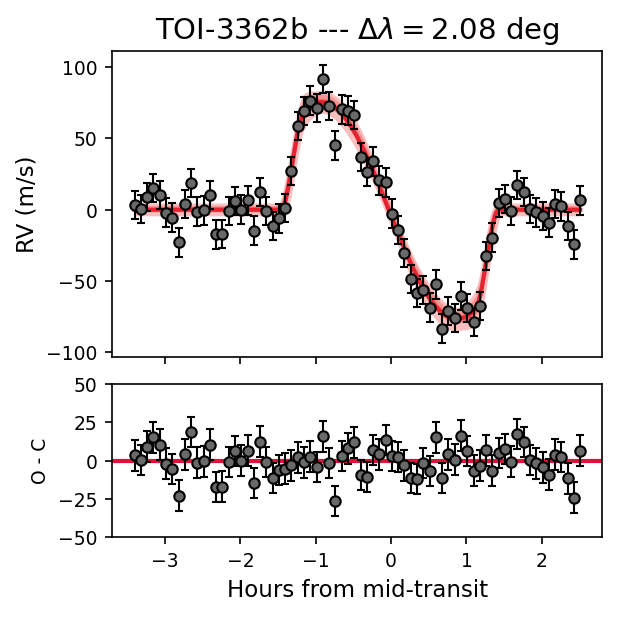

In [17]:
fig = plt.figure(figsize=(4,4),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 6)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, :], sharex = ax1)

t0 = results.vals["t0_p1"]
P = results.vals["per_p1"]

jitter = results.vals["sigma_ESPRESSO"]
gamma = results.vals["gamma_ESPRESSO"]
times_model_plot = (times_models_espresso-t0-78*P)*24.
times, data, error = results.data.x["ESPRESSO"],results.data.y["ESPRESSO"],np.sqrt(results.data.yerr["ESPRESSO"]**2.0 + jitter**2.0)
times = (times-t0-78*P)*24.

ax1.plot(times_model_plot,np.quantile(rm_models,0.5,axis=0),lw=2,color="crimson",zorder=-10)
ax1.fill_between(times_model_plot,np.quantile(rm_models,0.16,axis=0),np.quantile(rm_models,0.84,axis=0),alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
ax1.fill_between(times_model_plot,np.quantile(rm_models,0.2,axis=0),np.quantile(rm_models,0.98,axis=0),alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
ax1.fill_between(times_model_plot,np.quantile(rm_models,0.0015,axis=0),np.quantile(rm_models,0.9985,axis=0),alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
ax1.errorbar(times,data-gamma,error,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('RV (m/s)',fontsize=11)
ax1.set_title(r"TOI-3362b --- $\Delta\lambda = $"+str(round(np.std(results.chain["lam_p1"]),2))+" deg", fontsize=14)
res = data-rm_model_obs

ax2.errorbar(times,res,error,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
ax2.axhline(0.0,lw=2,color="crimson",zorder=-10)
ax2.set_ylim(-50,50)
#ax2.set_xticks([-3,-2,-1,0,1,2])
ax2.set_xlabel(r'Hours from mid-transit',fontsize=11)
ax2.set_ylabel('O - C')

plt.show()